# Lending Club Data: Loan Risk Prediction Model

* LendingClub is an American peer-to-peer lending company, headquartered in San Francisco, California.
* LendingClub enables borrowers to create unsecured (no collateral required) personal loans between $\$1,000$ and $\$40,000$. 
* The standard loan period is three years. 
* Investors can search and browse the loan listings on the LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose.
* Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

**Data source: https://www.kaggle.com/wordsforthewise/lending-club on Kaggle.**

### Import required Python library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', None,'display.max_rows', 155)

# Ploting options
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
%time df_loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

CPU times: user 34.6 s, sys: 7.99 s, total: 42.6 s
Wall time: 43.1 s


In [3]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


**There are 151 features in the data set.**

## Features descriptions

*Features escriptions taken from https://www.kaggle.com/wendykan/lending-club-loan-data.*

In [4]:
pd.read_excel('LCDataDictionary.xlsx')

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [5]:
def view_cat_plot(df,col_name,rotate=False):
    df_ = df[col_name].value_counts(dropna=False,normalize=True)*100
    if rotate:
        sns.barplot(x=df_.values,y=df_.index)
        plt.xlabel('Percentage')
        plt.ylabel(col_name)
    else:   
        sns.barplot(x=df_.index,y=df_.values) 
        plt.xlabel(col_name)
        plt.ylabel('Percentage')

## Target variable: Loan status

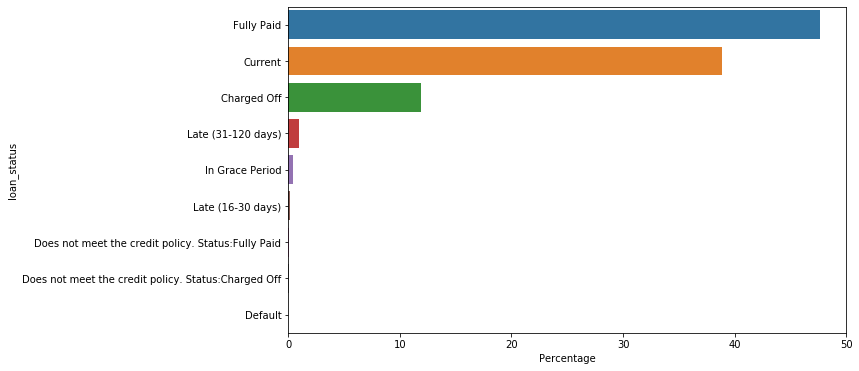

In [6]:
view_cat_plot(df_loan,'loan_status',rotate=True)

### Select binary classitication: "Fully Paid" and "Charged Off" 

In [7]:
#df[df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')}
df=df_loan.loc[df_loan['loan_status'].isin(['Fully Paid','Charged Off'])]

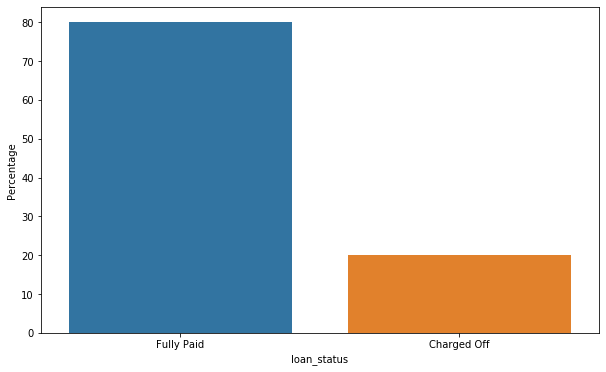

In [8]:
view_cat_plot(df,'loan_status')

**Target variable is imbalance: May need to use SMOTE from imblearn.over_sampling to balance the target variable**

##### Convert target variable to numeric 

In [9]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

# Feature Selection/Engneering: Dimensionality Reduction
* **missing data**
    * Drop feature if missiing value is greater than **MV_FEATURE*100** percent
    * Drop the sample observations with NaN value (approx 12 percent.)
* categorical varaibles
* pairwise correlations

In [2]:
# Drop feature if missiing value is MV_FEATURE*100 percent
MV_FEATURE = 0.5

# Drop categorical feature if the number of categories exceeds 
CV_MAX = 30

# Drop one of the features if a pairwise correlation is greater than PC_MAX
PC_MAX=0.95

### Dealing with missing data

In [11]:
df_null = pd.DataFrame({'Count': df.isna().sum(),'Percent': df.isna().mean()*100})

In [12]:
df_null_filtered = df_null[df_null['Percent'] > 10].sort_values(by='Percent',ascending=False)

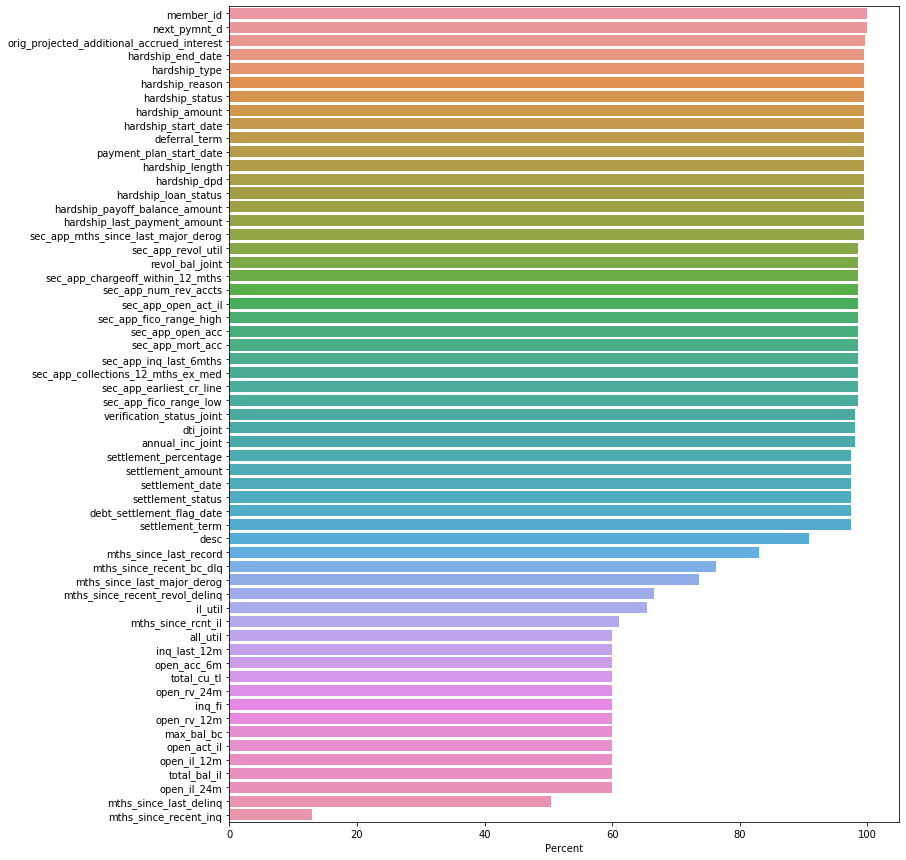

In [13]:
plt.figure(figsize=(12,15))
sns.barplot(x='Percent',y=df_null_filtered.index,data=df_null_filtered)

#### Drop any features with more than 50% missing values


In [14]:
df.dropna(axis=1,thresh=int(MV_FEATURE*len(df_loan)),inplace=True)

In [15]:
df.shape

(1345310, 93)

In [16]:
# Fraction of samples with matimum missing value
frac_nan = df.isna().sum().max()/len(df)
print(f'NaN sample obervations: {(frac_nan*100):g}%.')

NaN sample obervations: 12.9391%.


#### We do have a large sample. So, drop any rows with NaN value.

In [17]:
df.dropna(inplace=True)

In [18]:
print(f'We do have {str(df.shape[0])[:-3]}k obserbations remaining for further processing.')

We do have 986k obserbations remaining for further processing.


### Catagorical variables

In [19]:
df_object = df.select_dtypes(['object'])

In [20]:
df_object.nunique().sort_values(ascending=False)

id                      986013
url                     986013
emp_title               291427
title                    31897
zip_code                   938
earliest_cr_line           717
last_credit_pull_d          81
last_pymnt_d                79
issue_d                     77
addr_state                  51
sub_grade                   35
purpose                     14
emp_length                  11
grade                        7
home_ownership               6
verification_status          3
disbursement_method          2
initial_list_status          2
application_type             2
term                         2
debt_settlement_flag         2
pymnt_plan                   1
hardship_flag                1
dtype: int64

##### Dorp features with many catagories > CV_MAX  or single catatory

In [21]:
drop_list_many_catagories = list(df_object.nunique()[(df_object.nunique()>CV_MAX) | (df_object.nunique() == 1)].index)

In [22]:
df.drop(labels=drop_list_many_catagories,axis=1,inplace=True)

In [23]:
df.select_dtypes(['object']).nunique()

term                     2
grade                    7
emp_length              11
home_ownership           6
verification_status      3
purpose                 14
initial_list_status      2
application_type         2
disbursement_method      2
debt_settlement_flag     2
dtype: int64

## Let's investigate the categorical variables

### Term

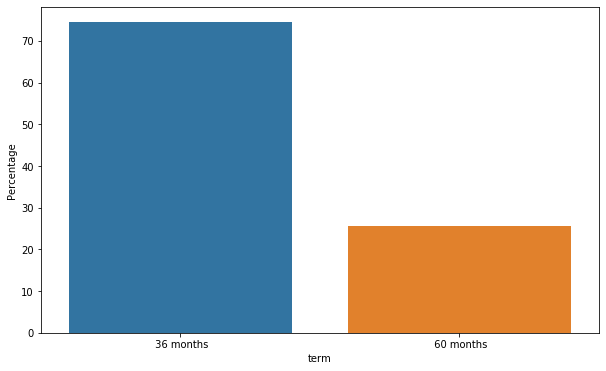

In [24]:
view_cat_plot(df,'term')

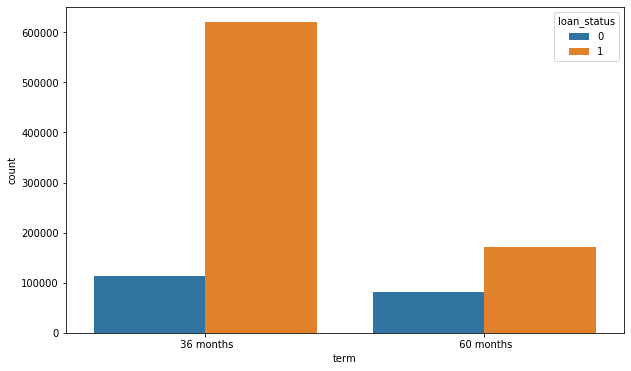

In [25]:
sns.countplot(x='term',data=df,hue='loan_status')

In [26]:
df['term']=df['term'].apply(lambda tm: np.int8(tm.split()[0]))

### Grade

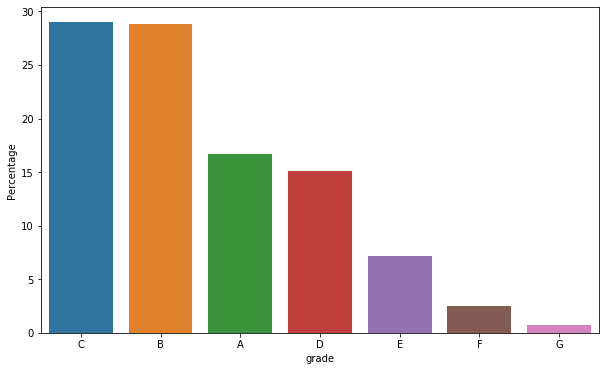

In [27]:
view_cat_plot(df,'grade')

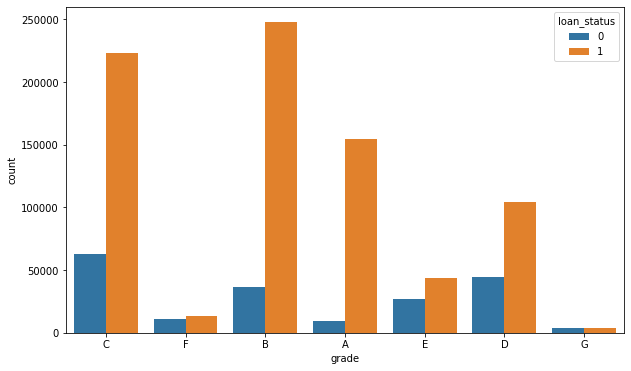

In [28]:
sns.countplot(x='grade',data=df,hue='loan_status')

### Employ Length

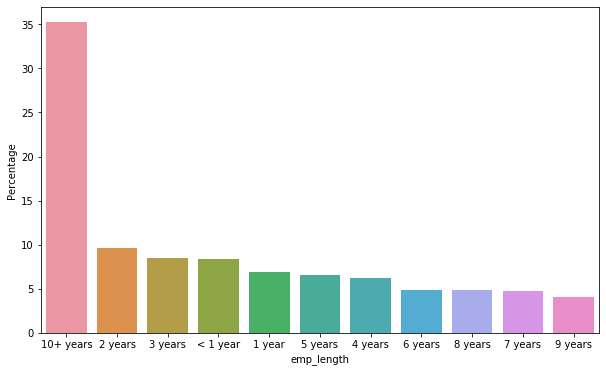

In [29]:
view_cat_plot(df,'emp_length')

##### Convert catagory to numeric type

In [30]:
df['emp_length'].replace(to_replace=['10+ years','< 1 year'],value=['10 years','0 year'],inplace=True)

In [31]:
df['emp_length'] = df['emp_length'].apply(lambda year: np.int8(year.split()[0]))

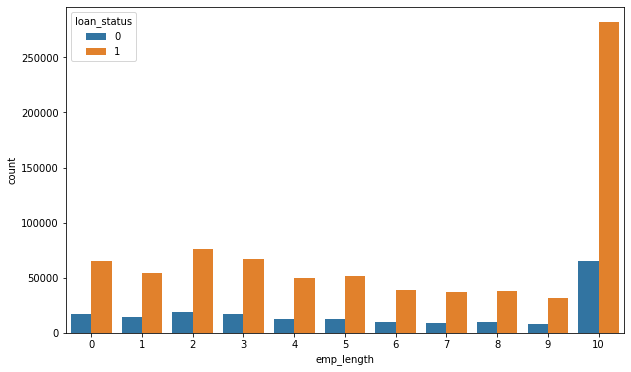

In [32]:
sns.countplot(x='emp_length',data=df,hue='loan_status')

### Home Ownership

In [33]:
df['home_ownership'].value_counts()

MORTGAGE    508439
RENT        376568
OWN         100731
ANY            209
OTHER           35
NONE            31
Name: home_ownership, dtype: int64

In [34]:
df['home_ownership'].replace(['ANY','NONE'],'OTHER',inplace=True)

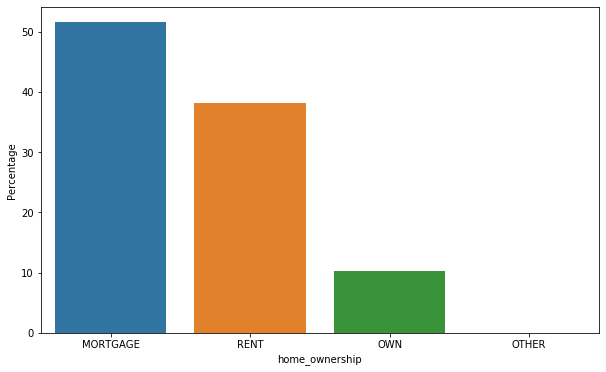

In [35]:
view_cat_plot(df,'home_ownership')

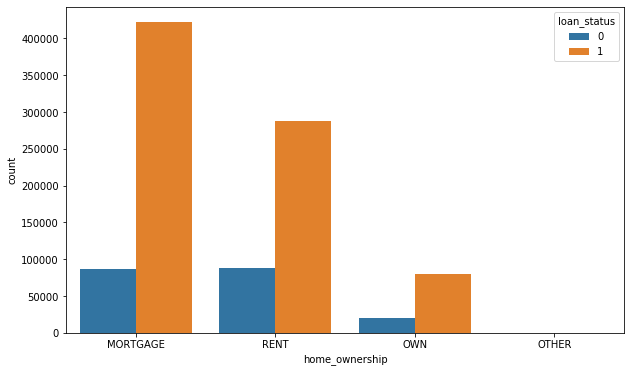

In [36]:
sns.countplot(x='home_ownership',data=df,hue='loan_status')

### Varification status

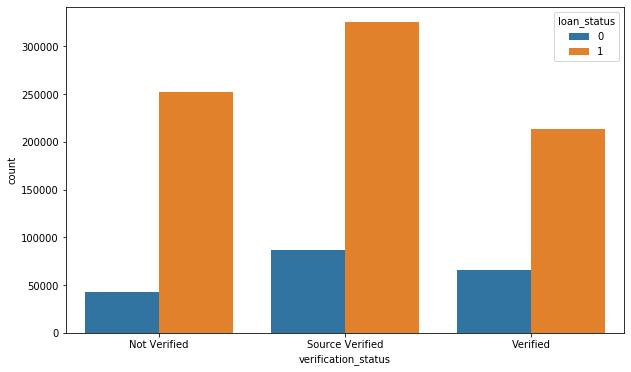

In [37]:
sns.countplot(x='verification_status',data=df,hue='loan_status')

## Purpose

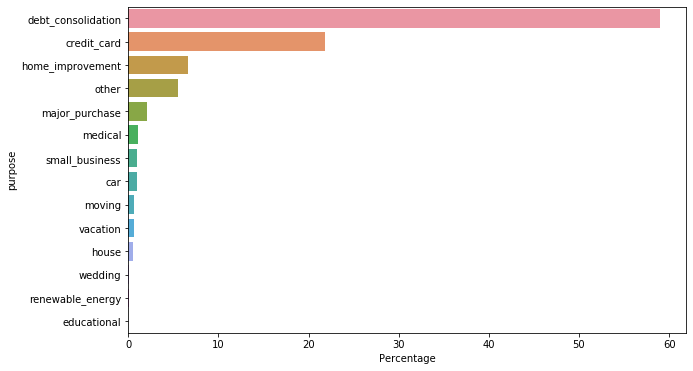

In [38]:
view_cat_plot(df,'purpose',rotate=True)

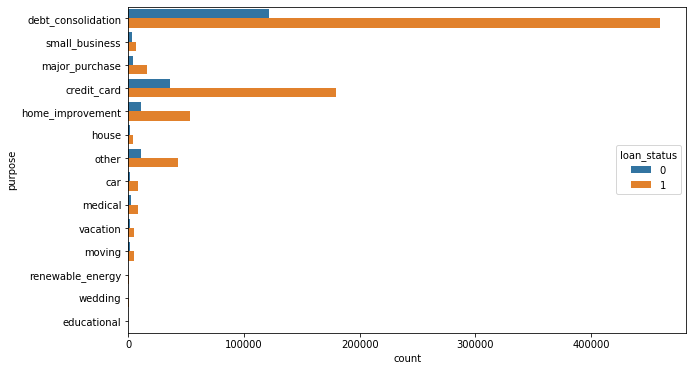

In [39]:
sns.countplot(y='purpose',data=df,hue='loan_status')

In [40]:
df['initial_list_status'].value_counts()

w    602363
f    383650
Name: initial_list_status, dtype: int64

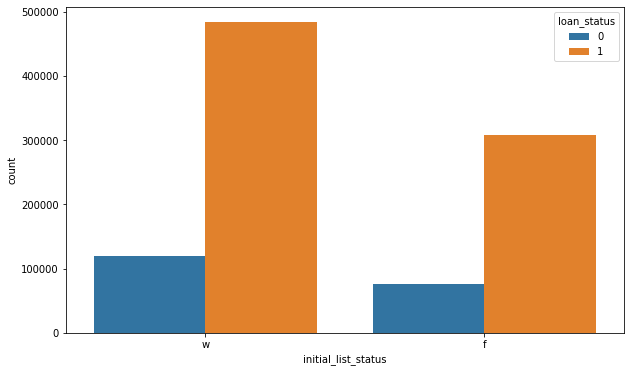

In [41]:
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

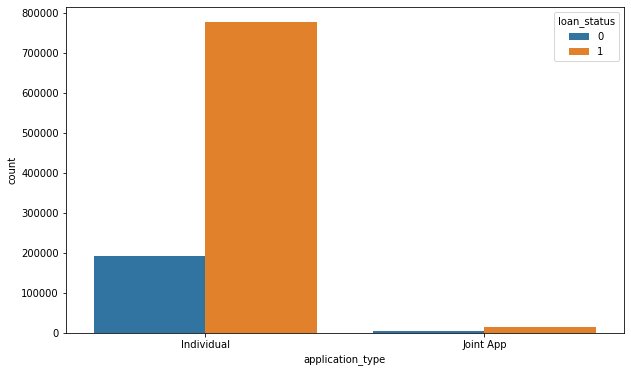

In [42]:
sns.countplot(x='application_type',data=df,hue='loan_status')

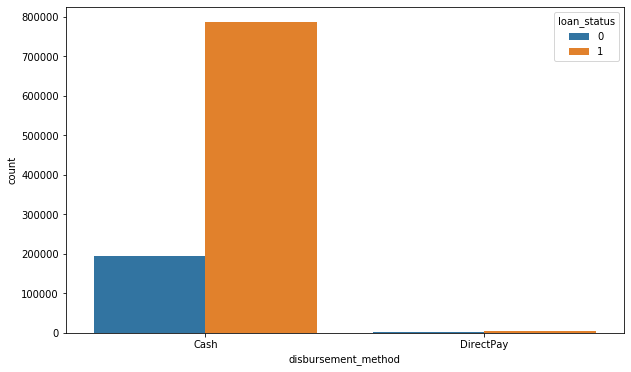

In [43]:
sns.countplot(x='disbursement_method',data=df,hue='loan_status')

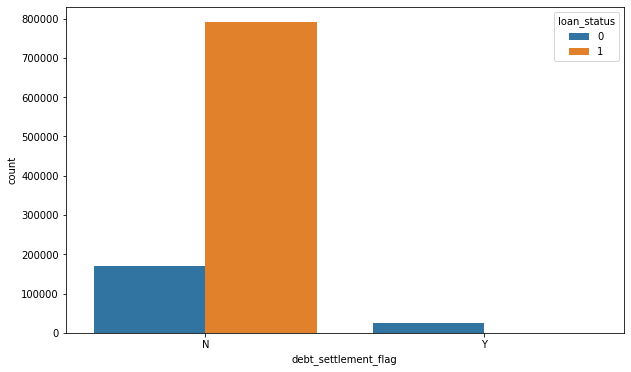

In [44]:
sns.countplot(x='debt_settlement_flag',data=df,hue='loan_status')

In [45]:
cat_var = df.select_dtypes(['object']).nunique()
cat_var

grade                    7
home_ownership           4
verification_status      3
purpose                 14
initial_list_status      2
application_type         2
disbursement_method      2
debt_settlement_flag     2
dtype: int64

In [46]:
dummy_list = list(cat_var.index)

#### Convert catorotical variable into dummy variables
* Use .get_dumies from pandas or OneHotEncoder from sklearn.preprocessing

In [47]:
dummies = pd.get_dummies(df[dummy_list],drop_first = True)

In [48]:
df.drop(dummy_list,axis=1,inplace=True)

In [49]:
#df = pd.concat([df,dummies],axis=1)

In [50]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import make_column_transformer

In [51]:
#column_trans = make_column_transformer((OneHotEncoder(),dummy_list),remainder='passthrough')
#column_trans.fit_transform(df)

## Pairwise correlation

In [52]:
corr_stack = df.corr().stack()
corr = corr_stack[corr_stack.index.get_level_values(0) != corr_stack.index.get_level_values(1)]

In [53]:
pair_corr_high = corr[corr > PC_MAX]
pair_corr_high

loan_amnt                funded_amnt                1.000000
                         funded_amnt_inv            0.999994
                         installment                0.952037
funded_amnt              loan_amnt                  1.000000
                         funded_amnt_inv            0.999994
                         installment                0.952038
funded_amnt_inv          loan_amnt                  0.999994
                         funded_amnt                0.999994
                         installment                0.951994
installment              loan_amnt                  0.952037
                         funded_amnt                0.952038
                         funded_amnt_inv            0.951994
fico_range_low           fico_range_high            1.000000
fico_range_high          fico_range_low             1.000000
open_acc                 num_sats                   0.999313
total_pymnt              total_pymnt_inv            0.999995
                        

In [54]:
# dropping ALL duplicte values 
drop_pair_list = pair_corr_high.drop_duplicates().index.get_level_values(1).unique() 
print(f'Dropped following highly pairwise correlated features:\n {drop_pair_list.values}')

Dropped following highly pairwise correlated features:
 ['funded_amnt' 'funded_amnt_inv' 'installment' 'fico_range_high'
 'num_sats' 'total_pymnt_inv' 'total_rec_prncp' 'collection_recovery_fee'
 'tot_hi_cred_lim' 'num_rev_tl_bal_gt_0']


In [55]:
df.drop(drop_pair_list,axis=1,inplace=True)

## Exploratory data analysis for a few sample numeric valriables

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986013 entries, 0 to 2260697
Data columns (total 62 columns):
loan_amnt                     986013 non-null float64
term                          986013 non-null int64
int_rate                      986013 non-null float64
emp_length                    986013 non-null int64
annual_inc                    986013 non-null float64
loan_status                   986013 non-null int64
dti                           986013 non-null float64
delinq_2yrs                   986013 non-null float64
fico_range_low                986013 non-null float64
inq_last_6mths                986013 non-null float64
open_acc                      986013 non-null float64
pub_rec                       986013 non-null float64
revol_bal                     986013 non-null float64
revol_util                    986013 non-null float64
total_acc                     986013 non-null float64
out_prncp                     986013 non-null float64
out_prncp_inv                 

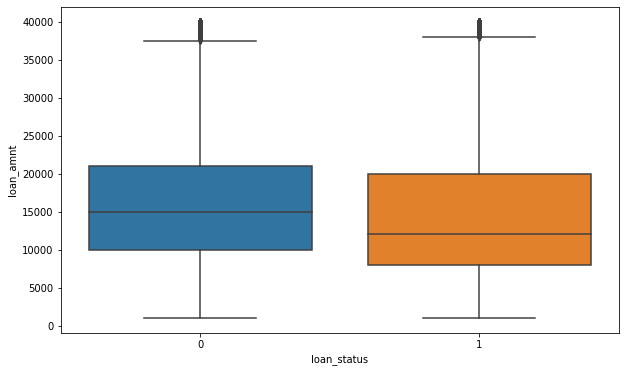

In [57]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

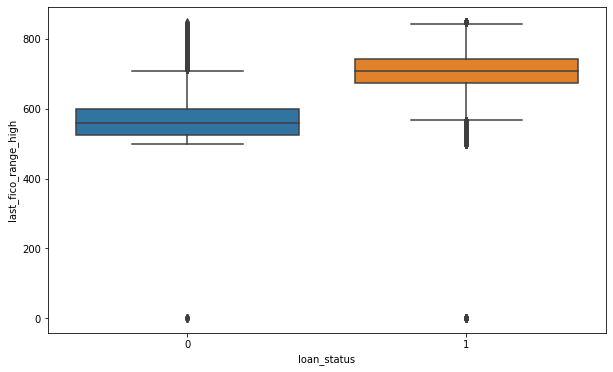

In [58]:
sns.boxplot(x='loan_status',y='last_fico_range_high',data=df)

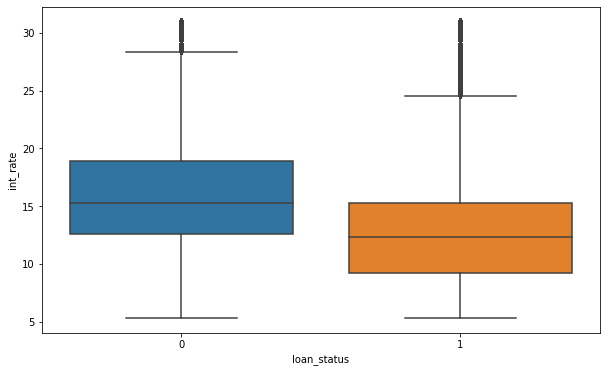

In [59]:
sns.boxplot(x='loan_status',y='int_rate',data=df)

In [60]:
df = pd.concat([df,dummies],axis=1)

In [61]:
print(f'{df.shape[1]} selected fetures names: \n {df.columns.values}')

90 selected fetures names: 
 ['loan_amnt' 'term' 'int_rate' 'emp_length' 'annual_inc' 'loan_status'
 'dti' 'delinq_2yrs' 'fico_range_low' 'inq_last_6mths' 'open_acc'
 'pub_rec' 'revol_bal' 'revol_util' 'total_acc' 'out_prncp'
 'out_prncp_inv' 'total_pymnt' 'total_rec_int' 'total_rec_late_fee'
 'recoveries' 'last_pymnt_amnt' 'last_fico_range_high'
 'last_fico_range_low' 'collections_12_mths_ex_med' 'policy_code'
 'acc_now_delinq' 'tot_coll_amt' 'tot_cur_bal' 'total_rev_hi_lim'
 'acc_open_past_24mths' 'avg_cur_bal' 'bc_open_to_buy' 'bc_util'
 'chargeoff_within_12_mths' 'delinq_amnt' 'mo_sin_old_il_acct'
 'mo_sin_old_rev_tl_op' 'mo_sin_rcnt_rev_tl_op' 'mo_sin_rcnt_tl'
 'mort_acc' 'mths_since_recent_bc' 'mths_since_recent_inq'
 'num_accts_ever_120_pd' 'num_actv_bc_tl' 'num_actv_rev_tl' 'num_bc_sats'
 'num_bc_tl' 'num_il_tl' 'num_op_rev_tl' 'num_rev_accts'
 'num_tl_120dpd_2m' 'num_tl_30dpd' 'num_tl_90g_dpd_24m'
 'num_tl_op_past_12m' 'pct_tl_nvr_dlq' 'percent_bc_gt_75'
 'pub_rec_bankruptcies

In [62]:
print(f'Final data contains {str(df.shape[0])[:-3]}k observations and {df.shape[1]} features.')

Final data contains 986k observations and 90 features.


### write processed data to the file

In [63]:
df.to_csv('loan_data_final_'+str(PC_MAX)+'.csv',index=None)